# 映画のレビューの感情分析

## 【ライブラリのインポート】

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

%matplotlib inline
sns.set_style("whitegrid")
# plt.style.use("fivethirtyeight")

from sklearn.feature_extraction.text import CountVectorizer

CountVectorizerをインスタンス化

In [2]:
vect = CountVectorizer()

解析されたフレーズごとに分類精度（正しく予測されたラベルの割合）で評価される。<br>
0:否定的<br>
1:やや否定的<br>
2:中立<br>
3:やや肯定的<br>
4:肯定的

提出形式・・・テストセット内の各フレーズについて、感情のラベルを予測する。<br>
**PhraseID, Sentiment**という形式で提出する。

## 【データセットをpandasで読みこむ。】

In [3]:
train_df = pd.read_csv("train.tsv", delimiter='\t')
test_df = pd.read_csv("test.tsv", delimiter='\t')

In [4]:
train_df[train_df['Phrase'].isnull()]

,PhraseId,SentenceId,Phrase,Sentiment


In [5]:
train_df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [6]:
test_df.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


#### 欠損値の確認
欠損値のあるデータを見てたところ、欠損値は存在しなかった。
（ちなみに、欠損値が存在する行を削除する手法を、「リストワイズ法」という。<br>
これは、訓練データにのみ使用することができる。<br>
訓練データの削除は「削除したデータは学習に使用しない」と捉えることができるが、<br>テストデータは予測しなければならないデータなので、削除を行なった場合は、欠損値をもつサンプルに対する予測を破棄することになり、望ましくない。

In [7]:
train_df.isnull().sum()

PhraseId      0
SentenceId    0
Phrase        0
Sentiment     0
dtype: int64

In [8]:
test_df.isnull().sum()

PhraseId      0
SentenceId    0
Phrase        0
dtype: int64

## 【探索的データ分析】

・スコア「２」のレビューが多かった（「中立」的なレビュー）<br>
・同一なレビューは無い。（freq=1だから）

In [9]:
train_df.describe()

,PhraseId,SentenceId,Sentiment
count,156060.000000,156060.000000,156060.000000
mean,78030.500000,4079.732744,2.063578
std,45050.785842,2502.764394,0.893832
min,1.000000,1.000000,0.000000
25%,39015.750000,1861.750000,2.000000
50%,78030.500000,4017.000000,2.000000
75%,117045.250000,6244.000000,3.000000
max,156060.000000,8544.000000,4.000000


In [10]:
train_df.describe(exclude='number')

,Phrase
count,156060
unique,156060
top,A series of escapades demonstrating the adage ...
freq,1


文字数を算出してみる。

In [11]:
train_df['Phrase_len'] = train_df.Phrase.apply(len)
train_df.head()

,PhraseId,SentenceId,Phrase,Sentiment,Phrase_len
0,1,1,A series of escapades demonstrating the adage ...,1,188
1,2,1,A series of escapades demonstrating the adage ...,2,77
2,3,1,A series,2,8
3,4,1,A,2,1
4,5,1,series,2,6


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'Phrase Length')

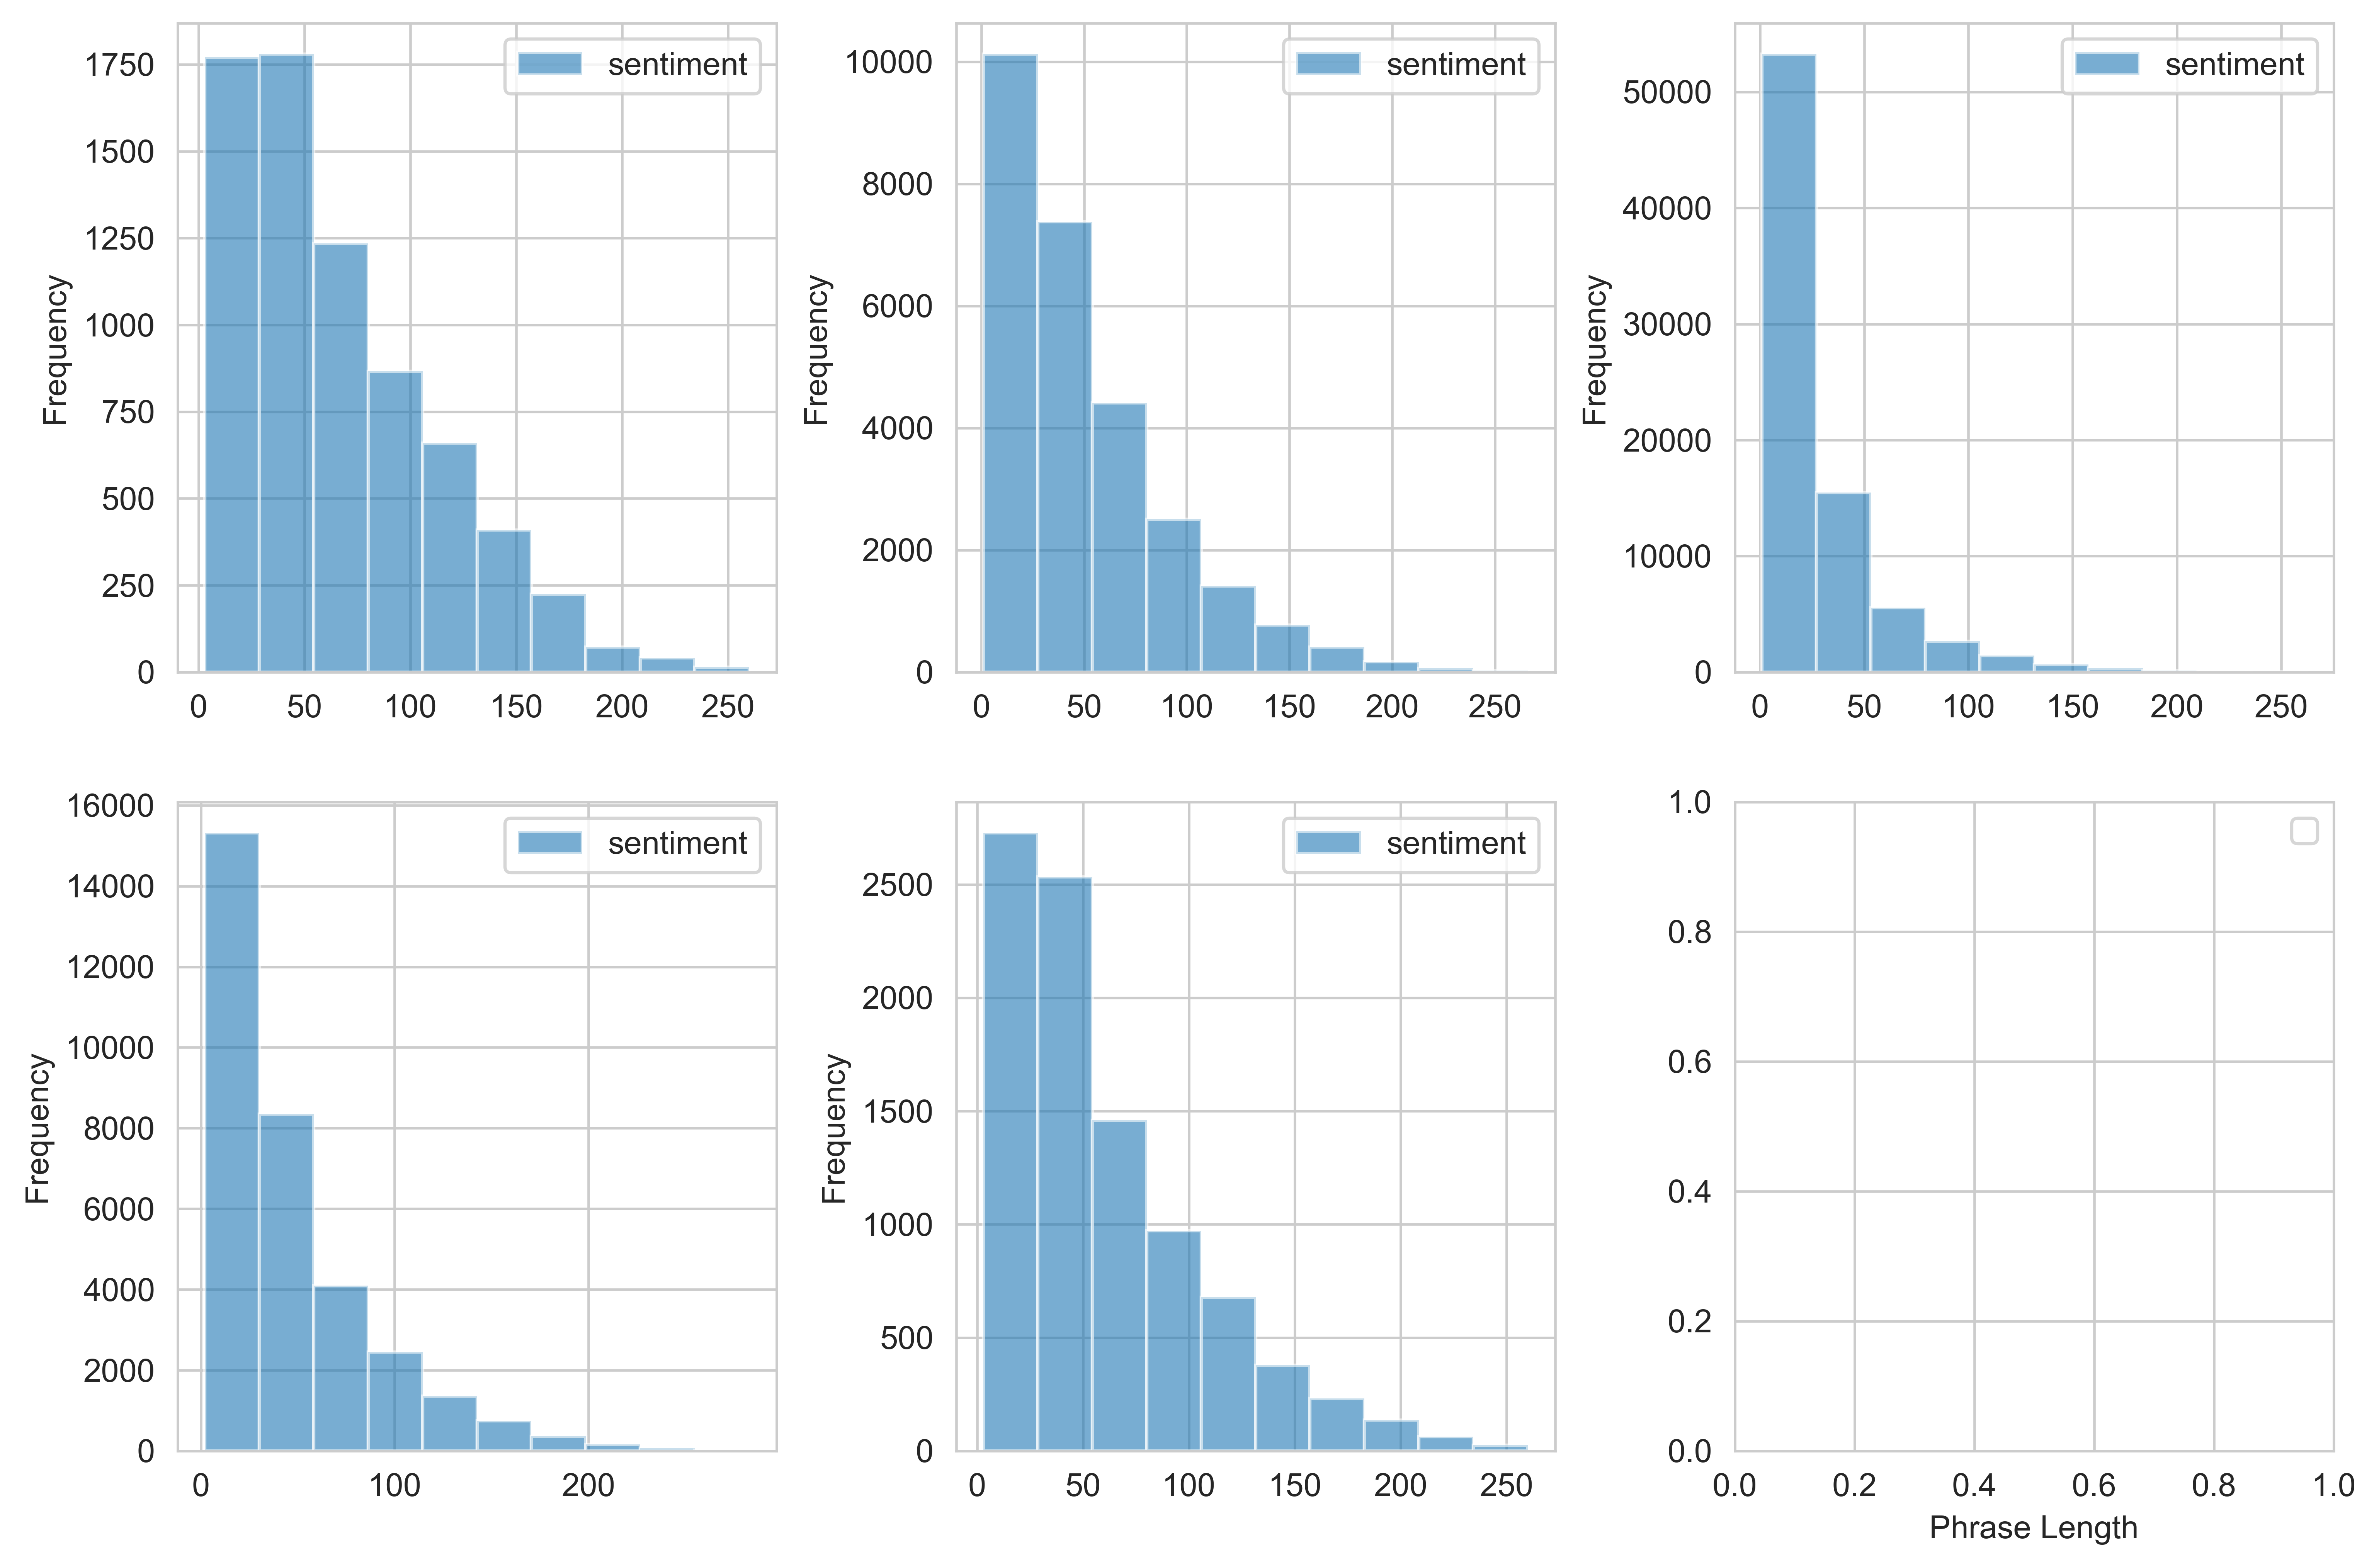

In [12]:
# plt.figure(figsize=(12, 8), dpi=600)
fig, ax = plt.subplots(2, 3, figsize=(12, 8), dpi=600)
plt.subplots_adjust(wspace=0.3, hspace=0.2)
plt.xlabel("Phrase Length")

train_df[train_df.Sentiment==0].Phrase_len.plot(ax=ax[0,0], kind='hist', label='sentiment', alpha=0.6, legend=True)
train_df[train_df.Sentiment==1].Phrase_len.plot(ax=ax[0,1], kind='hist', label='sentiment', alpha=0.6, legend=True)
train_df[train_df.Sentiment==2].Phrase_len.plot(ax=ax[0,2], kind='hist', label='sentiment', alpha=0.6, legend=True)
train_df[train_df.Sentiment==3].Phrase_len.plot(ax=ax[1,0], kind='hist', label='sentiment', alpha=0.6, legend=True)
train_df[train_df.Sentiment==4].Phrase_len.plot(ax=ax[1,1], kind='hist', label='sentiment', alpha=0.6, legend=True)

plt.legend()
plt.xlabel("Phrase Length")

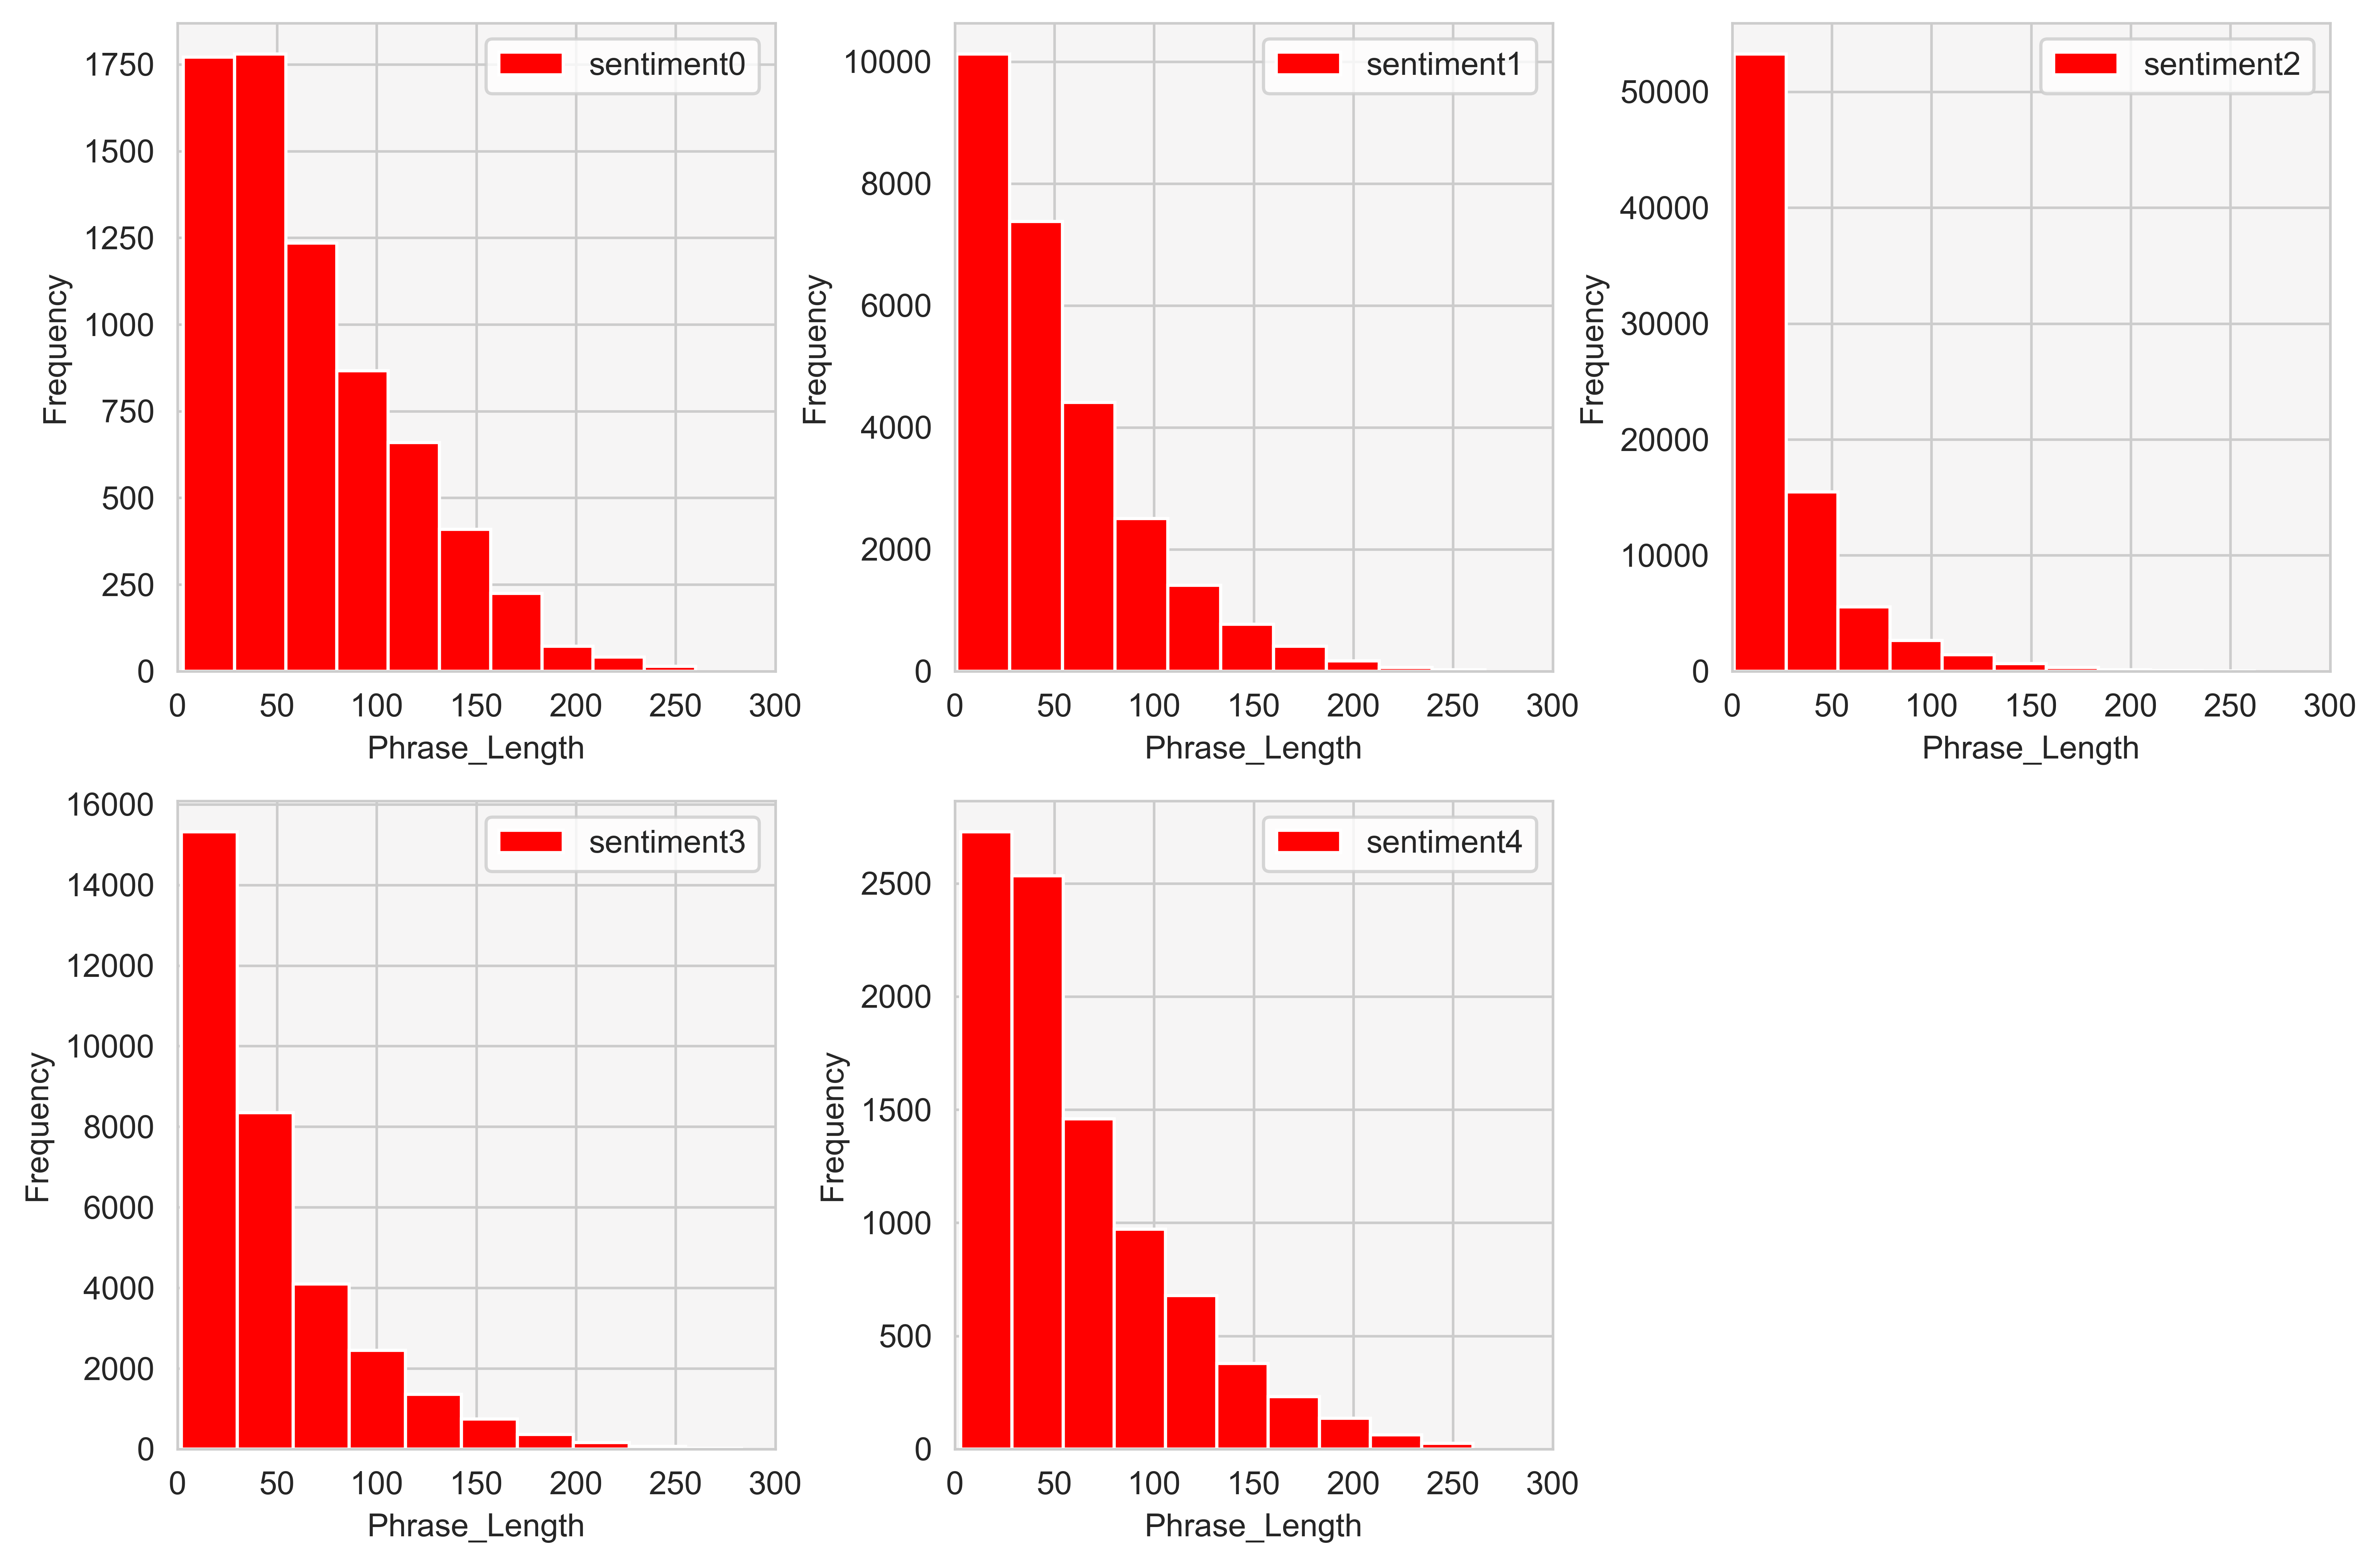

In [13]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8), dpi=600)
plt.subplots_adjust(wspace=0.3, hspace=0.2)

background_color = "#f6f5f5"

run_no = 0
for row in range(0,2):
    for col in range(0, 3):
        locals()["ax"+str(run_no)] = train_df[train_df.Sentiment==run_no].Phrase_len.plot(ax=ax[row, col], kind='hist', label='sentiment'+str(run_no), legend=True, color="red")
        locals()["ax"+str(run_no)].set_xlabel("Phrase_Length")
        locals()["ax"+str(run_no)].set_xlim(0, 300)
        locals()["ax"+str(run_no)].set_facecolor(background_color)
        run_no += 1

ax5.remove()
plt.show()

・分布の形は大体同じ。<br>
　└文が短いレビューほど多い。<br>
　└５０文字以内がほとんど。<br>
・中立的なレビューの数が多い。

In [14]:
# fig = plt.figure(figsize=(12, 8), dpi=600)
# plt.subplots_adjust(wspace=0.3, hspace=0.2)

# ax0 = fig.add_subplot(231)
# train_df[train_df.Sentiment==0].Phrase_len.plot(kind='hist', color='blue', label='sentiment=0', alpha=0.6, legend=True)
# ax0.set_xlabel("Phrase Length")

# ax1 = fig.add_subplot(232)
# train_df[train_df.Sentiment==1].Phrase_len.plot(kind='hist', color='red', label='sentiment=1', alpha=0.6, legend=True)
# ax1.set_xlabel("Phrase Length")

# ax2 = fig.add_subplot(233)
# train_df[train_df.Sentiment==2].Phrase_len.plot(kind='hist', color='yellow', label='sentiment=2', alpha=0.6, legend=True)
# ax2.set_xlabel("Phrase Length")

# ax3 = fig.add_subplot(234)
# train_df[train_df.Sentiment==3].Phrase_len.plot(kind='hist', color='green', label='sentiment=3', alpha=0.6, legend=True)
# ax3.set_xlabel("Phrase Length")

# ax4 = fig.add_subplot(235)
# train_df[train_df.Sentiment==4].Phrase_len.plot(kind='hist', color='pink', label='sentiment=4', alpha=0.6, legend=True)
# ax4.set_xlabel("Phrase Length")

In [15]:
train_df[train_df.Sentiment==0].describe()

,PhraseId,SentenceId,Sentiment,Phrase_len
count,7072.000000,7072.000000,7072.0,7072.000000
mean,81035.048784,4241.946126,0.0,66.092336
std,43705.802913,2434.936265,0.0,46.510140
min,102.000000,3.000000,0.0,3.000000
25%,44891.000000,2177.000000,0.0,28.000000
50%,81796.000000,4221.000000,0.0,54.000000
75%,117412.000000,6265.250000,0.0,94.000000
max,155974.000000,8539.000000,0.0,260.000000


In [16]:
train_df[train_df.Sentiment==1].describe()

,PhraseId,SentenceId,Sentiment,Phrase_len
count,27273.000000,27273.000000,27273.0,27273.000000
mean,80495.252447,4216.860265,1.0,50.602281
std,45125.763868,2510.922820,0.0,40.942068
min,1.000000,1.000000,1.0,1.000000
25%,41566.000000,2001.000000,1.0,20.000000
50%,81334.000000,4192.000000,1.0,38.000000
75%,119969.000000,6416.000000,1.0,70.000000
max,156057.000000,8544.000000,1.0,266.000000


In [17]:
train_df[train_df.Sentiment==2].describe()

,PhraseId,SentenceId,Sentiment,Phrase_len
count,79582.000000,79582.000000,79582.0,79582.000000
mean,76527.962441,3997.699090,2.0,28.861929
std,45351.766531,2516.081021,0.0,29.067204
min,2.000000,1.000000,2.0,1.000000
25%,36798.000000,1743.250000,2.0,11.000000
50%,76188.500000,3909.000000,2.0,19.000000
75%,115680.500000,6164.000000,2.0,35.000000
max,156060.000000,8544.000000,2.0,262.000000


In [18]:
train_df[train_df.Sentiment==3].describe()

,PhraseId,SentenceId,Sentiment,Phrase_len
count,32927.000000,32927.000000,32927.0,32927.000000
mean,78409.828378,4098.831597,3.0,47.743402
std,44596.812258,2480.081070,0.0,41.075281
min,22.000000,1.000000,3.0,2.000000
25%,40094.000000,1919.000000,3.0,19.000000
50%,78068.000000,4018.000000,3.0,33.000000
75%,117275.500000,6257.000000,3.0,64.000000
max,156058.000000,8544.000000,3.0,283.000000


In [19]:
train_df[train_df.Sentiment==4].describe()

,PhraseId,SentenceId,Sentiment,Phrase_len
count,9206.000000,9206.000000,9206.0,9206.000000
mean,80052.598197,4189.713448,4.0,60.817076
std,44310.325650,2466.092532,0.0,46.227102
min,64.000000,2.000000,4.0,3.000000
25%,42766.750000,2064.250000,4.0,25.000000
50%,80185.000000,4131.000000,4.0,46.000000
75%,118439.000000,6327.750000,4.0,84.000000
max,156011.000000,8541.000000,4.0,260.000000


# テキストの前処理

In [20]:
import string
from nltk.corpus import stopwords

def text_process(mess):
    # 句読点を除去
    # ストップワード除去
    # 削除されたテキストのリストを返す。
    
    STOPWORDS = stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']
    
    # 句読点が文字の中にあるかどうかチェックする。
    nopunc = [char for char in mess if char not in string.punctuation]
    
    # 再び文字を結そうして、文字列を形成する。
    nopunc = ''.join(nopunc)
    
    # ストップワードを削除する。
    return ' '.join([word for word in nopunc.split() if word.lower() not in STOPWORDS])

In [21]:
train_df.head()

,PhraseId,SentenceId,Phrase,Sentiment,Phrase_len
0,1,1,A series of escapades demonstrating the adage ...,1,188
1,2,1,A series of escapades demonstrating the adage ...,2,77
2,3,1,A series,2,8
3,4,1,A,2,1
4,5,1,series,2,6


In [22]:
train_df['Clean_Phrase'] = train_df.Phrase.apply(text_process)

In [23]:
train_df.head()

,PhraseId,SentenceId,Phrase,Sentiment,Phrase_len,Clean_Phrase
0,1,1,A series of escapades demonstrating the adage ...,1,188,series escapades demonstrating adage good goos...
1,2,1,A series of escapades demonstrating the adage ...,2,77,series escapades demonstrating adage good goose
2,3,1,A series,2,8,series
3,4,1,A,2,1,
4,5,1,series,2,6,series


【疑問点】<br>
短すぎるレビューは除去してしまった方がいいのでは？<br>
短すぎる文章(１０文字以下くらい)が、Sentimetが「2」に分類されているから、Sentiment「2」のデータが多いのでは？

In [24]:
# train_df[train_df.Phrase_len < 10].head(10000)
# # ここで、head()の引数を調整して多くのデータを見てみたが、単語1つで意味が理解できないものが多く、それらはSentimentが[2]に分類されていた。

In [25]:
train_df[train_df.Phrase_len < 20].count()

PhraseId        59370
SentenceId      59370
Phrase          59370
Sentiment       59370
Phrase_len      59370
Clean_Phrase    59370
dtype: int64

## ベクトル化

レビューをベクトル化して、機械学習が理解できるように調整する。
1, ある単語が各メッセージに何回出現しているか数える。
2, 頻出たんごが低くなるように重み付けをする。
3, ベクトルを単位長に正規化し、元のテキストの長さを抽象化する。（L2ノルム）

In [ ]:
from collections import Counter

words = train_df